In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# River chemistry data for the pan-Arctic

Aim: have monthly mean chemistry for big suite of chemical variables required by marine modellers, for all RADR catchments + Greenland, for the period 1980-2019

Approach:

1. Big 6 rivers: use observed data from Arctic-GRO

    Will probably need to do some patching and cleaning to get chem for the full period.To do:

    * Quick plot of time series to see how long the record is, gaps, etc. in each river
    * For rivers where there are big gaps, try to derive a regression with Q:
        * For the three sites where chemistry is measured a long way away from discharge, adjust the datetime by offsetting, so that the new timestamp matches the day when discharge is measured
        * For each chem variable, and for a variety of temporal aggregations (e.g. daily, monthly):
            * Plot QC
            * Plot logQ-logC
            * Fit linear regression. How good is regression? Get slope b. Value of b: dilution, mobilisation, static?
        * Use regressions with Q to derive daily or monthly concentration in each river for full baseline period.
    
    Will probably also use these regressions to predict the future, but first need to decide how to predict future changes in Q...


2. Predict water quality in the rest of the unmonitored AO

    How to do this?
    * Lit review. Catchment characteristics.
    * Focus in particular on DOC, DIC, Hg. Rest can be based on same methods used in A20 hindcast Andre and Phil did.

## User input

In [56]:
# Location of cleaned discharge data
q_cleaned_daily_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'
q_cleaned_monthly_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'

in_chem_file = r'~/shared/pan_arctic_data/water_quality/ArcticGRO/ArcticGRO Water Quality Data_2022-02.xlsx'
out_folder = r'../output/qc_regressions/'

## Read in chem data

In [3]:
xl = pd.ExcelFile(in_chem_file)
rivers_li = xl.sheet_names[:-1]
rivers_li

['Ob', 'Yenisey', 'Lena', 'Kolyma', 'Yukon', 'Mackenzie']

In [4]:
chem_dict = {}  # key: river name (from rivers_li)

for river in rivers_li:
    df = pd.read_excel(in_chem_file, sheet_name=river, header=8, index_col=2,
                       skiprows=[9], parse_dates=True)
    chem_dict[river] = df

chem_dict['Ob'].head()

,Phase,River,ID,Discharge,Temp,pH,Cond,Alk,A254,A375,...,POC (1),POC-13C (1),PON (1),PON-15N (1),Sample depth 2,TSS (2),POC (2),POC-13C (2),PON (2),PON-15N (2)
Date,,,,,,,,,,,,,,,,,,,,,
2003-07-16,PARTNERS,Ob',NaN,31200.0,19.8,7.5,NaN,44.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-05,PARTNERS,Ob',NaN,3553.0,-1.0,7.0,NaN,130.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-15,PARTNERS,Ob',NaN,34500.0,10.5,7.7,NaN,32.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-17,PARTNERS,Ob',NaN,34500.0,12.6,7.7,NaN,34.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-07-28,PARTNERS,Ob',NaN,26000.0,20.0,7.5,NaN,38.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
chem_dict['Ob'].columns

Index(['Phase', 'River', 'ID', 'Discharge', 'Temp', 'pH', 'Cond', 'Alk',
       'A254', 'A375', 'A412', 'A420', 'A440', 'H2O-2H', 'H2O-18O', 'DOC',
       'DOC-13C', 'DOC-14C', 'DOC-fm', 'TDN', 'NO3', 'NH4', 'TDP', 'PO4',
       'SiO2', 'Na', 'K', 'Mg', 'Ca', 'As', 'Ba', 'Cl', 'SO4', 'Li', 'Rb',
       'Sr', 'U', 'F', 'UTHg', 'UMeHg', 'TSS', 'POC', 'POC-13C', 'POC-14C',
       'POC-fm', 'PON', 'PON-15N', 'Sample depth 1', 'TSS (1)', 'POC (1)',
       'POC-13C (1)', 'PON (1)', 'PON-15N (1)', 'Sample depth 2', 'TSS (2)',
       'POC (2)', 'POC-13C (2)', 'PON (2)', 'PON-15N (2)'],
      dtype='object')

# Read in discharge data

In [6]:
q_dict = {}

for river in rivers_li:
    if river == "Yenisey":  # Name used for chem data
        river2 = "Yenisei"  # Name used for discharge data
    else:
        river2 = river
    fpath = os.path.join(q_cleaned_daily_folder, "%s_daily_1980-2019.csv" % river2)
    q_df = pd.read_csv(fpath, index_col=0, parse_dates=True)
    q_dict[river] = q_df

q_dict['Ob'].head()

,discharge
date,
1980-01-01,7360.0
1980-01-02,7350.0
1980-01-03,7350.0
1980-01-04,7320.0
1980-01-05,7290.0


# Make dataset including chem and Q

To do this, first need to apply date offset to get chem data as seen at discharge stations. 3 rivers monitor discharge and chemistry in different places, so following method used by Holmes et al. (): Calculate lag time between the two sampling stations by assuming river velocities of 1.5 m/s. Therefore use measured concentrations and assume they were observed at downstream locations on day + lag. Work out lags to apply as follows:
* Lena: water chem is 520 m U/S of discharge. Lag of ~4 days. Add 4 days to the WQ dates.
* Yenisey: WQ is 250 km D/S of Q. Lag of ~-2 days. Subtract 2 days.
* Kolyma: WQ is 150 km D/S of Q. Lag of ~-1 day. Subtract 1 day.

Also add discharge data for sampling dates. The ArcticGRO water quality data includes discharge data already. This is usually the same as the ArcticGRO discharge data for the same date, but not always. Perhaps it is because of the data cleaning I did, or patching, or perhaps they made errors too. Either way, I will use my cleaned data as the basis, rather than the discharge data included with the chem data.

Also truncate to just the chem variables of interest.

In [134]:
chem_vars = ['Alk', 'DOC',
             'TDN', 'NO3', 'NH4',
             'TDP', 'PO4',
             'SiO2', 'UTHg', 'UMeHg', 'POC', 'PON']

lag_dict = {'Lena': 4,
            'Yenisey': -2,
            'Kolyma': -1}

chem_q_daily_dict = {}
chem_q_monthly_dict = {}

for river in rivers_li:
    chem_df = chem_dict[river].copy()

    # Drop unwanted cols
    chem_df = chem_df.loc[:, chem_vars]

    # Convert to daily frequency, in prep for time shift for some rivs, and converting
    # to monthly freq for all
    chem_df_daily = chem_df.asfreq('D')
    chem_df_daily = chem_df_daily.loc[:'2019-12-31']  # Truncate to period of interest

    # For some rivs, apply time shift so chem dates are on the day at which that water parcel
    # would be seen at the gauging station ('ish)
    if river in lag_dict.keys():
        chem_df_daily = chem_df_daily.shift(lag_dict[river])

    # Add discharge data to the chem data (from cleaned ArcticGRO discharge files,
    # rather than using the 'Discharge' column in the WQ data)
    chem_df_daily['Q'] = q_dict[river].loc[chem_df_daily.index]

    # Also calculate monthly mean discharge and chem
    chem_df_monthly = chem_df_daily.resample('M').agg(np.mean)

    # Drop rows where all are NaNs (i.e. drop the daily or monthly freq)
    chem_df_daily.dropna(subset=chem_df_daily.columns.difference(['Q']),
                         how="all", inplace=True)
    chem_df_monthly.dropna(subset=chem_df_monthly.columns.difference(['Q']),
                           how="all", inplace=True)

    # Add to dicts
    chem_q_daily_dict[river] = chem_df_daily
    chem_q_monthly_dict[river] = chem_df_monthly

# Check at Lena. DOC was 5.2 on 2003-08-12. Should now be 5.2 on 2003-08-16. Ok.
print("Check of offset at Lena:")
print(chem_q_daily_dict['Lena']['DOC'].head())

# Check new Q column is ok. Find: identical for US rivs, bit diff for Sib ones.
# So code is working ok.
# print(chem_q_daily_dict['Mackenzie'].loc[:, ['Discharge', 'Q']])
print("\n" "Check of daily data for Ob:")
print(chem_q_daily_dict['Ob'].head())

print("\n" "Check of monthly data for Ob:")
print(chem_q_monthly_dict['Ob'].head())

Check of offset at Lena:
Date
2003-08-16     5.20
2004-04-13     6.70
2004-06-09    14.81
2004-06-11    12.41
2004-08-23     6.70
Name: DOC, dtype: float64

Check of daily data for Ob:
              Alk    DOC   TDN     NO3     NH4    TDP  PO4   SiO2  UTHg  \
Date                                                                      
2003-07-16   44.9  10.98  0.45   49.02   42.86  59.80  NaN   3.86   NaN   
2004-04-05  130.6   5.50  0.96  189.09  669.52  15.24  NaN  19.11   NaN   
2004-06-15   32.9   8.71  0.39  147.07    8.54  29.57  NaN   4.77   NaN   
2004-06-17   34.4   8.71  0.40  173.68   16.67  29.57  NaN   4.92   NaN   
2004-07-28   38.4  12.01  0.45   11.21   13.87  52.33  NaN   4.54   NaN   

            UMeHg   POC     PON        Q  
Date                                      
2003-07-16    NaN  1.23  140.07  31200.0  
2004-04-05    NaN  1.12  120.46   3553.0  
2004-06-15    NaN  2.18  294.14  34500.0  
2004-06-17    NaN  2.28  282.94  34500.0  
2004-07-28    NaN  1.65  326.36

# Plot discharge and chem data

## Time series

In [8]:
# Function to plot time series of chem and Q together for each river
def plot_timeseries(chem_var, rivers_li, chem_dict, q_dict):

    fig = plt.figure()

    for river in rivers_li:

        fig = plt.figure(figsize=(15, 8))

        # Plot chem data
        ax = fig.add_subplot()
        chem_df = chem_dict[river][chem_var]
        chem_df.plot(marker='o', color='k', linestyle='none', grid=True, ax=ax)
        ax.set_ylabel(chem_var)
        ax.set_xlabel("")
        ax.legend('Chem', loc='upper left')

        # Plot Q data
        ax2 = ax.twinx()
        q_df = q_dict[river].loc['2003-01-01':]
        q_df.plot(ax=ax2)
        ax2.set_ylabel('Q')
        ax2.legend('Q', loc='upper right')

        # Tidy
        plt.title("%s" % str(river))
        plt.tight_layout()
        plt.show()

        # plt.savefig(os.path.join(chem_graph_folder,
        #                          'raw_data_%s-%s_%s' % (st_yr, end_yr, str(site))))

<Figure size 432x288 with 0 Axes>

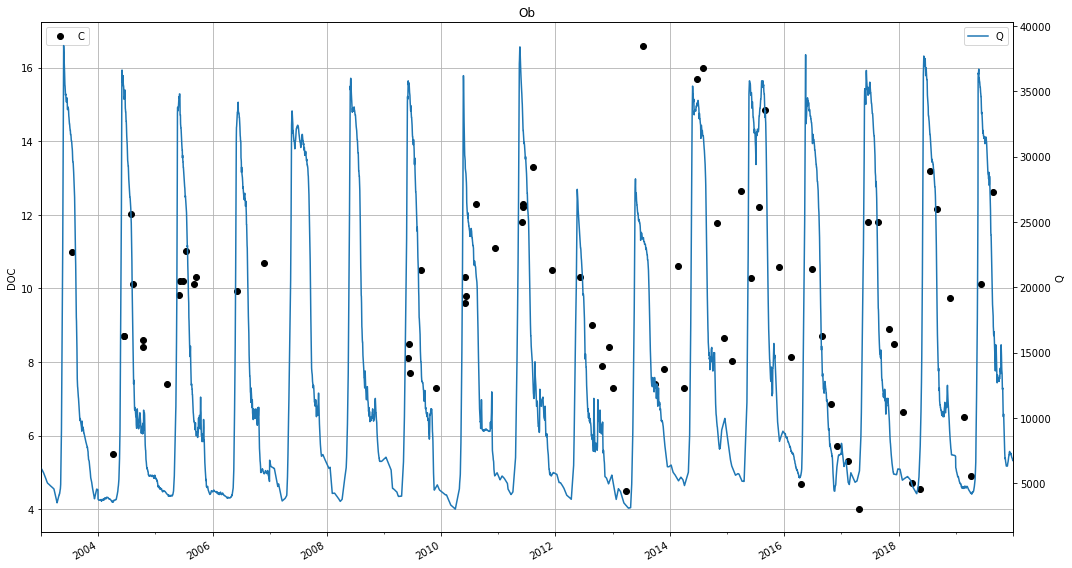

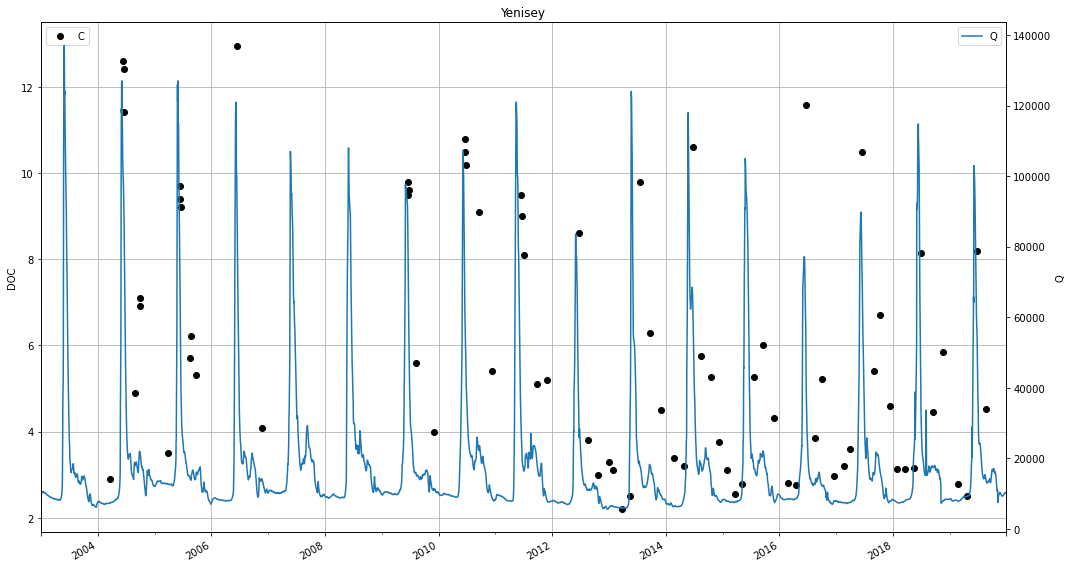

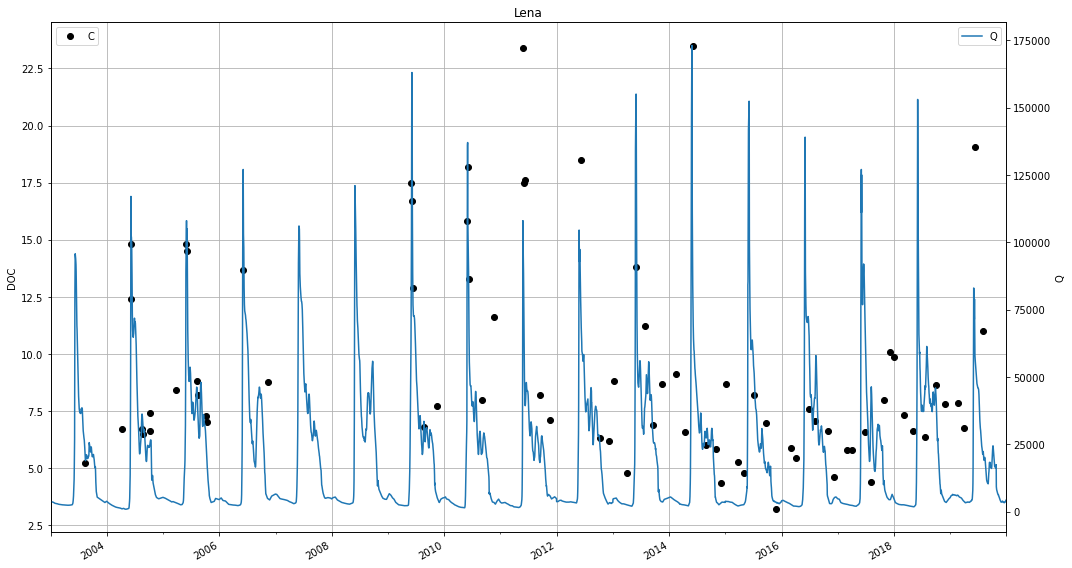

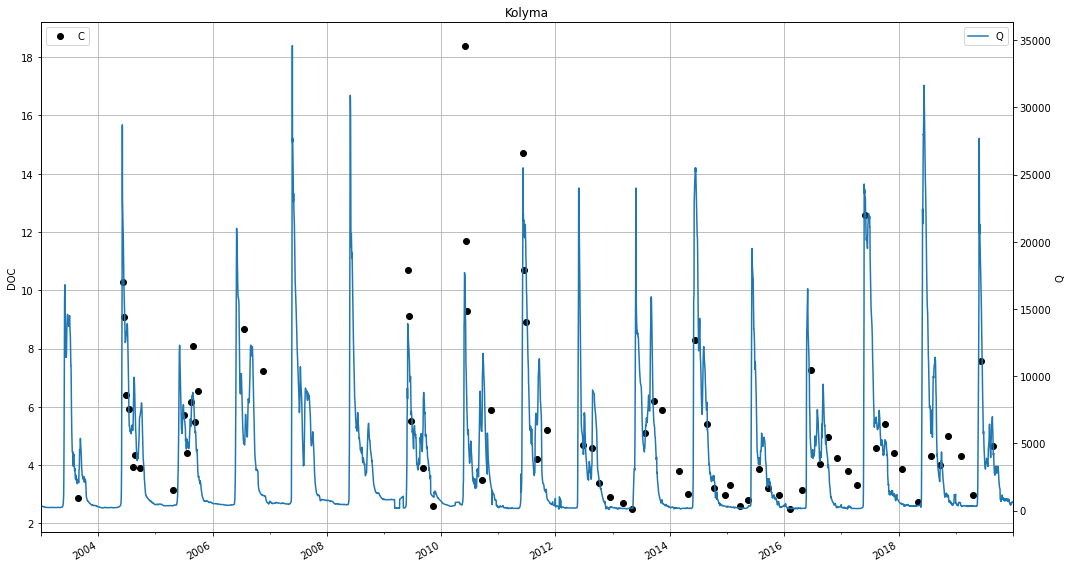

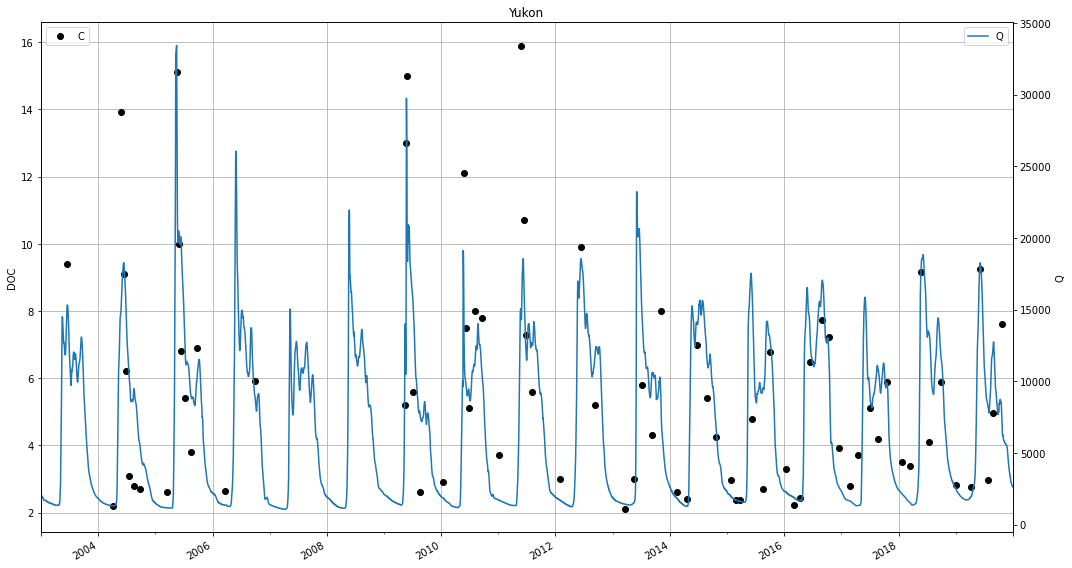

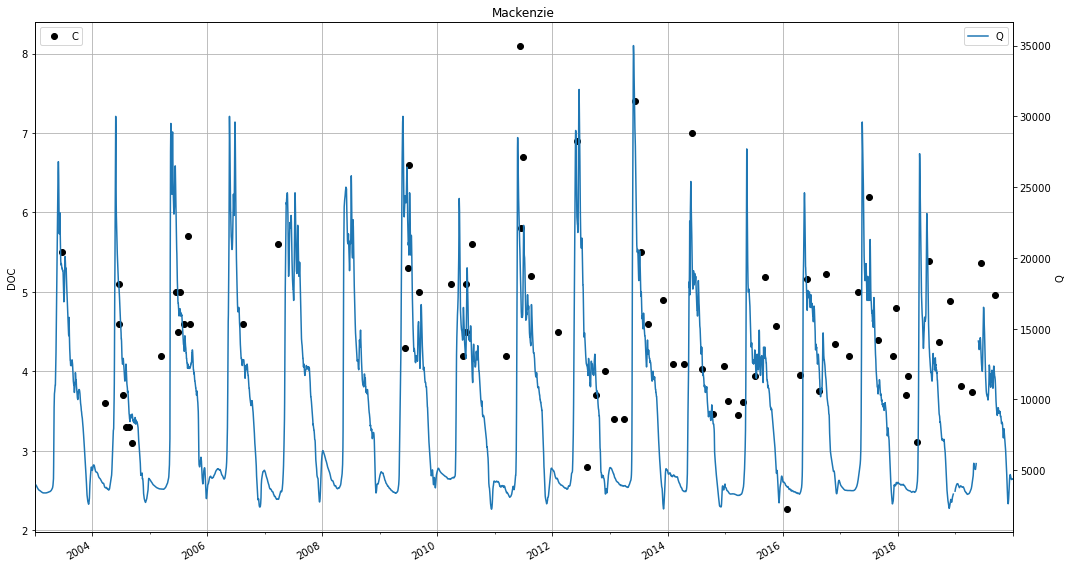

In [9]:
plot_timeseries('DOC', rivers_li, chem_dict, q_dict)

## Chem vs Q

In [135]:
def q_c_linear_regression(chem_q_dict, chem_var, out_folder,
                          log_q=False, log_chem=False,
                          monthly=False):
    """ """

    linear_reg_df = pd.DataFrame()

    fig, axs = plt.subplots(nrows=1, ncols=len(rivers_li),
                            sharex=False, sharey=False, figsize=(17, 3))
    axs = axs.flatten()

    for i, river in enumerate(rivers_li):
        df = chem_q_dict[river].loc[:, ["Q", chem_var]]
        # print(df.isnull().sum())  # 1 NA in DOC in Ob, Lena and Kolyma
        df = df.dropna()
        if len(df) < 20:
            continue  # i.e. don't do for this river, not enough data

        # If desired, log transform the data first
        if log_q is True:
            df["Q"] = np.log10(df["Q"])
            xlabel = "Log10 Q"
        else:
            xlabel = "Q"
        if log_chem is True:
            df[chem_var] = np.log10(df[chem_var])
            ylabel = "Log10 %s" % chem_var
        else:
            ylabel = chem_var

        x = df["Q"].values.reshape((-1, 1))
        y = df[chem_var].values

        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)

        r_sq = model.score(x, y)
        fit_c = model.intercept_
        fit_m = model.coef_

        np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
        linear_reg_df.loc[river, ["R2", "m", "c"]] = [r_sq, fit_c, fit_m]

        # Plot output of linear regression
        axs[i].scatter(x, y, color="black")
        axs[i].plot(x, y_pred, color="blue", linewidth=2)
        axs[i].set_xlabel(xlabel)
        if i == 0:
            axs[i].set_ylabel(ylabel)
        axs[i].set_title(river)

    # Sort out file names
    if monthly is True:
        freq_str = "monthly"
    else:
        freq_str = "daily"

    linear_reg_df.to_csv(
        os.path.join(
            out_folder,
            "qc_regression_%s_%s_logq-%s_logchem_%s.csv"
            % (chem_var, freq_str, log_q, log_chem),
        ),
        index_label="River",
    )
    plt.savefig(
        os.path.join(
            out_folder,
            "qc_scatter_%s_%s_logq-%s_logchem_%s.png"
            % (chem_var, freq_str, log_q, log_chem),
        )
    )

    print(linear_reg_df)

                 R2         m         c
Ob         0.295192  7.385659  0.000122
Yenisey    0.754356  3.442433  0.000098
Lena       0.528598  6.404924  0.000093
Kolyma     0.645068  3.313480  0.000382
Yukon      0.635344  1.904042  0.000402
Mackenzie  0.395186  3.532030  0.000101


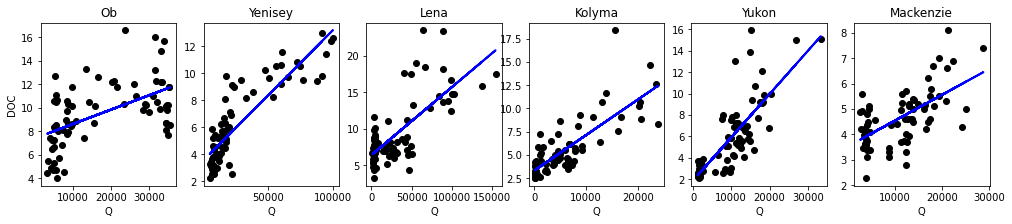

In [136]:
q_c_linear_regression(chem_q_daily_dict, 'DOC', out_folder)

                 R2         m         c
Ob         0.388704 -0.050109  0.245084
Yenisey    0.765380 -1.467648  0.515811
Lena       0.403097  0.113346  0.196220
Kolyma     0.587119 -0.048981  0.219944
Yukon      0.646444 -1.043845  0.454359
Mackenzie  0.278163 -0.008463  0.168304


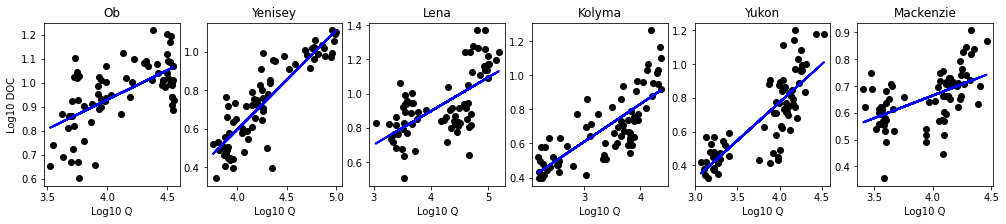

In [87]:
q_c_linear_regression(chem_q_daily_dict, 'DOC', out_folder, log_chem=True, log_q=True)

                 R2         m         c
Ob         0.363505  6.993862  0.000161
Yenisey    0.630890  3.235087  0.000093
Lena       0.394289  6.272488  0.000120
Kolyma     0.254456  3.758769  0.000294
Yukon      0.463053  2.116229  0.000403
Mackenzie  0.377403  3.549857  0.000098


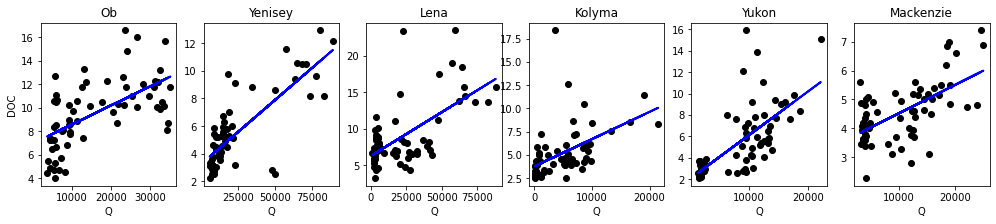

In [138]:
q_c_linear_regression(chem_q_monthly_dict, 'DOC', out_folder, log_chem=False, log_q=False, monthly=True)

                 R2         m         c
Ob         0.441850 -0.244877  0.294197
Yenisey    0.585264 -1.195910  0.446641
Lena       0.284486  0.176287  0.180623
Kolyma     0.377271  0.085593  0.174535
Yukon      0.568376 -0.989135  0.440305
Mackenzie  0.249677  0.015683  0.161368


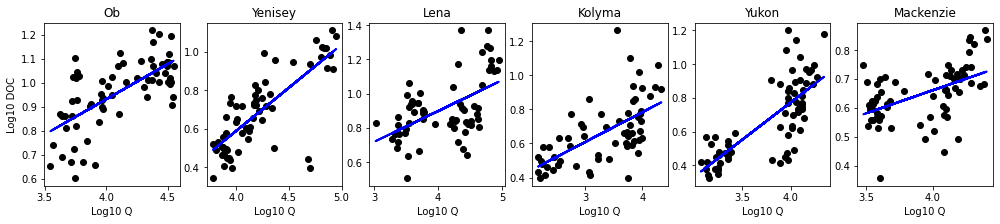

In [139]:
q_c_linear_regression(chem_q_monthly_dict, 'DOC', out_folder, log_chem=True, log_q=True, monthly=True)